In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fit_amps(x, y, match_y):
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    
    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y, x, fill_value='extrapolate')
    return f(match_y)

In [3]:
def fit_gamma(x, y):
    # for all points (x,y), calculate r and compare to predicted
    best_err = np.inf
    best_gamma = 0
    for gamma in np.linspace(-2, 3, 100):
        err = np.sum(np.abs( np.sqrt(x**2 + y**2 + gamma * x * y) - 1))
        if err < best_err:
            best_err = err
            best_gamma = gamma
    return best_gamma

In [4]:
def movie2bright(pt, mode='softmax'):
    if mode == 'max':
        return pt.max()
    elif mode == 'softmax':
        # frame-wise softmax
        return (np.exp(pt) / np.exp(pt).sum(axis=(0,1))).max(axis=(0,1)).max()
    elif mode == 'mean':
        # frame-wise mean
        return pt.mean(axis=(0,1)).max()
    else:
        raise ValueError('Unknown mode "' + mode + '"')

In [5]:
def get_isobrightness(data, exp_params, mode='max'):
    # This is the reference current that produces the reference brightness
    # we are trying to match
    amp_ref = exp_params['amp_ref']
    
    # Find reference brightness from single-electrode conditions
    # Condition 1
    x1 = data['cond1']['amp_E1']
    y1 = [movie2bright(f.data, mode) for f in data['cond1']['frames']]
    match_b1 = fit_amps(y1, x1, amp_ref)  # switch x1, y1
    
    # Condition 2
    x2 = data['cond2']['amp_E2']
    y2 = [movie2bright(f.data, mode) for f in data['cond2']['frames']]
    match_b2 = fit_amps(y2, x2, amp_ref)  # switch x1, y1
    
    gamma = []
    amp1 = []
    amp2 = []
    # For all other delays, compare delayed-pulse responses to match_b1 and match_b2
    for d in np.unique(data['cond3']['delay']):
        # indices where delay is d
        idx = np.where(data['cond3']['delay'] == d)[0]
        idx_start = idx[0]
        idx_end = idx[-1] + 1

        # From Condition 2 above
        plot_amp1 = [0]
        plot_amp2 = [1]

        # Condition 3
        x3 = data['cond3']['amp_E2'][idx_start:idx_end]
        y3 = [movie2bright(f.data, mode) for f in data['cond3']['frames'][idx_start:idx_end]]
        amp_b3 = fit_amps(x3, y3, match_b2)
        plot_amp1.append(data['cond3']['amp_E1'][2] / amp_ref)
        plot_amp2.append(amp_b3 / amp_ref)

        # Condition 5
        x5 = data['cond5']['amp_E1'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5 = fit_amps(x5, y5, match_b1)
        plot_amp1.append(amp_b5 / amp_ref)
        x5 = data['cond5']['amp_E2'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5 = fit_amps(x5, y5, match_b2)
        plot_amp2.append(amp_b5 / amp_ref)

        # Condition 4
        x4 = data['cond4']['amp_E1'][idx_start:idx_end]
        y4 = [movie2bright(f.data, mode) for f in data['cond4']['frames'][idx_start:idx_end]]
        amp_b4 = fit_amps(x4, y4, match_b1)
        plot_amp1.append(amp_b4 / amp_ref)
        plot_amp2.append(data['cond4']['amp_E2'][3] / amp_ref)

        # From Condition 1 above
        plot_amp1.append(1)
        plot_amp2.append(0)
        
        gamma.append(fit_gamma(np.array(plot_amp1), np.array(plot_amp2)))        
        amp1.append(plot_amp1)
        amp2.append(plot_amp2)
        
    return (amp1, amp2, gamma)

In [6]:
def plot_isobrightness(amp_E1, amp_E2, gamma, delay, exp_params, save_fig=True):
    pair = '(%s, %s)' % (exp_params['name_E1'], exp_params['name_E2'])
    plt.close()
    
    plt.plot(np.array(amp_E1).T, np.array(amp_E2).T, 'o-', label=0, linewidth=2)
    plt.plot([1, 0], [0, 1], '--')
    plt.xlabel('E1')
    plt.ylabel('E2')
    plt.legend(loc='upper right')
    plt.title(pair)
    plt.axis('equal')
    plt.legend(delay * 1000)

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.2, 0.2, 0.25, 0.25]
    ax2 = plt.axes([left, bottom, width, height])
    ax2.plot(gamma, 'o-k')
    ax2.plot([0, len(delay) - 1], [0, 0], ':k')
    ax2.plot([0, len(delay) - 1], [1, 1], ':k')
    plt.xticks(range(len(delay)), delay * 1000)
    plt.yticks([-1, 0, 1, 2])
    plt.ylim(-1, 2)
    
    if save_fig:
        filename = '%s%s_%s_%s_%s_%.1fX_iso_%s.jpg' % (exp_params['save_dir'], 
                                                         exp_params['name'], 
                                                         exp_params['name_E1'], 
                                                         exp_params['name_E2'], 
                                                         exp_params['date'], 
                                                         exp_params['fac_thresh'],
                                                         mode)
        plt.savefig(filename)
        print('Saved figure to %s' % filename)

In [7]:
def plot_gamma(all_gamma, delay, mode, prefix='', save_fig=True):
    plt.hist(np.array(all_gamma), stacked=True, label=delay * 1000, range=(-2, 3))
    plt.xlabel('gamma')
    plt.ylabel('count')
    plt.legend()
    plt.title('movie2brightness: ' + mode)
    if save_fig:
        filename = '%s%s%s_%s_%.1fX_gamma_%s.jpg' % (exp_params['save_dir'], 
                                                     prefix,
                                                     exp_params['name'],
                                                     exp_params['date'], 
                                                     exp_params['fac_thresh'],
                                                     mode)
        plt.savefig(filename)
        print('Saved figure to %s' % filename)

Loading file data/ecs_l1/nanduri_E2_E3_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C1_D1_2016-10-18_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E0_E4_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_A1_A2_2016-10-18_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E10_E6_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C3_C2_2016-10-18_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E2_E1_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C1_B1_2016-10-19_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E10_E5_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C3_B2_2016-10-19_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E6_E5_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C2_B2_2016-10-19_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E9_E5_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_B3_B2_2016-10-19_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E12_E13_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nandur

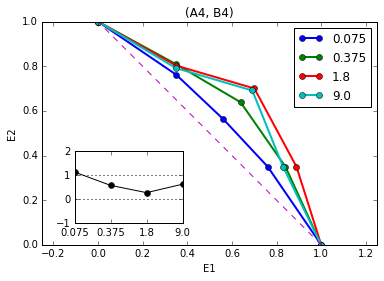

In [8]:
# how to get brightness from pulse train
# {'max', 'softmax', 'mean'}
mode = 'max'

prefix = 'data/ecs_l1/nanduri_'
suffix = '2016-10-19_1.5X.npz'

# all pairs that are 800um away
idx_E1 = [2, 0, 10, 2, 10, 6, 9, 12]
idx_E2 = [3, 4,  6, 1,  5, 5, 5, 13]

all_amp1 = []
all_amp2 = []
all_gamma = []
for E1, E2 in zip(idx_E1, idx_E2):
    # Load data from file
    filename = '%sE%d_E%d_%s' % (prefix, E1, E2, suffix)
    print('Loading file ' + filename)
    exp_data = np.load(filename)
    data = exp_data['data'][()]
    exp_params = exp_data['exp_params'][()]
    
    # calculate isobrightness curve
    amp1, amp2, gamma = get_isobrightness(data, exp_params, mode=mode)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)
    
    # find delays from file specs
    delay = np.unique(data['cond3']['delay'])
    plot_isobrightness(amp1, amp2, gamma, delay, exp_params)

Saved figure to data/ecs_l1/800um_nanduri_2016-10-19_1.5X_gamma_max.jpg


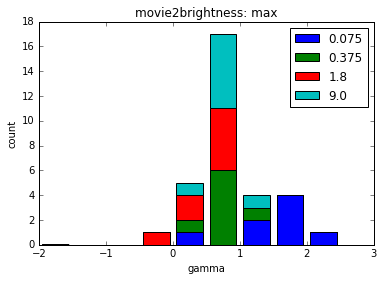

In [9]:
plot_gamma(all_gamma, delay, mode, prefix='800um_')

Loading file data/ecs_l1/nanduri_E5_E13_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_B2_B4_2016-10-19_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E4_E6_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_A2_C2_2016-10-20_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E9_E1_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_B3_B1_2016-10-20_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E0_E2_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_A1_C1_2016-10-20_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E0_E12_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_A1_A4_2016-10-20_1.5X_iso_max.jpg
Loading file data/ecs_l1/nanduri_E14_E2_2016-10-19_1.5X.npz
Saved figure to data/ecs_l1/nanduri_C4_C1_2016-10-20_1.5X_iso_max.jpg


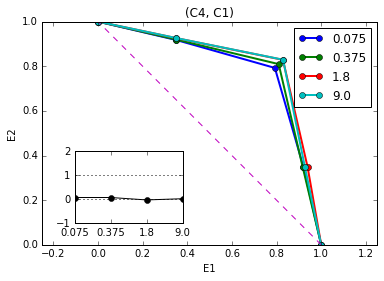

In [10]:
# how to get brightness from pulse train
# {'max', 'softmax', 'mean'}
mode = 'max'

# all pairs that are > 800um away
idx_E1 = [ 5, 4, 9, 0,  0, 14]
idx_E2 = [13, 6, 1, 2, 12,  2]

all_amp1 = []
all_amp2 = []
all_gamma = []
for E1, E2 in zip(idx_E1, idx_E2):
    # Load data from file
    filename = '%sE%d_E%d_%s' % (prefix, E1, E2, suffix)
    print('Loading file ' + filename)
    exp_data = np.load(filename)
    data = exp_data['data'][()]
    exp_params = exp_data['exp_params'][()]
    
    # calculate isobrightness curve
    amp1, amp2, gamma = get_isobrightness(data, exp_params, mode=mode)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)
    
    # find delays from file specs
    delay = np.unique(data['cond3']['delay'])
    plot_isobrightness(amp1, amp2, gamma, delay, exp_params)

Saved figure to data/ecs_l1/1600um_nanduri_2016-10-20_1.5X_gamma_max.jpg


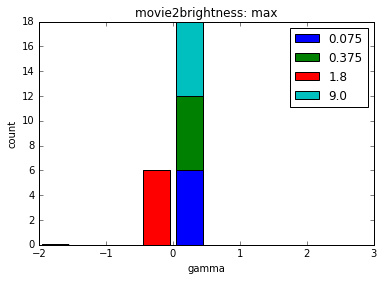

In [11]:
plot_gamma(all_gamma, delay, mode, prefix='1600um_')